In [1]:
import pandas as pd
import warnings 
import numpy as np
import talib
import talib.abstract as abstract

warnings.filterwarnings('ignore')

df = pd.read_csv('../price.csv',index_col=['stock_id','date'],parse_dates=['date'])
df = df.rename(columns={
    '開盤價':'open',
    '最高價':'high',
    '最低價':'low',
    '收盤價':'close',
    '成交金額':'volume'
})
df = df[['open','high','low','close','volume']]
df = df.loc[df['volume']>0]
df = df.apply(pd.to_numeric,errors='coerce')
df = df.loc['2330']
df

,open,high,low,close,volume
date,,,,,
2007-01-02,67.8,68.0,67.3,67.7,1768131919
2007-01-03,67.8,68.7,67.5,68.0,2875024398
2007-01-04,67.7,68.1,67.6,67.7,1514454033
2007-01-05,67.5,67.7,66.5,66.9,2048997239
2007-01-08,66.1,66.5,65.7,65.8,1595029837
...,...,...,...,...,...
2022-06-20,500.0,502.0,495.0,498.0,18267359790
2022-06-21,501.0,505.0,499.0,505.0,17298234720
2022-06-22,501.0,503.0,494.5,494.5,16630857096


Start date,2007-01-02
End date,2022-06-24
Total months,181
,Backtest
Annual return,22.276%
Cumulative returns,1996.92%
Annual volatility,21.548%
Sharpe ratio,1.04
Calmar ratio,0.82
Stability,0.97
Max drawdown,-27.062%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.06,2020-01-10,2020-03-17,2020-07-07,128
1,23.38,2015-03-19,2015-08-21,2016-03-09,255
2,21.08,2018-09-04,2019-01-02,2019-04-17,162
3,19.83,2013-05-07,2013-08-19,2014-03-11,221
4,19.77,2018-01-22,2018-06-26,2018-08-28,157


,open,high,low,close,volume,hold_連續跌,hold_創新高,hold_KD,hold_RSI,hold_willr,hold_bias,hold_number,real_hold,earn
date,,,,,,,,,,,,,,
2007-01-02,67.8,68.0,67.3,67.7,1768131919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-03,67.8,68.7,67.5,68.0,2875024398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-04,67.7,68.1,67.6,67.7,1514454033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-05,67.5,67.7,66.5,66.9,2048997239,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2007-01-08,66.1,66.5,65.7,65.8,1595029837,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-20,500.0,502.0,495.0,498.0,18267359790,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2022-06-21,501.0,505.0,499.0,505.0,17298234720,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2022-06-22,501.0,503.0,494.5,494.5,16630857096,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


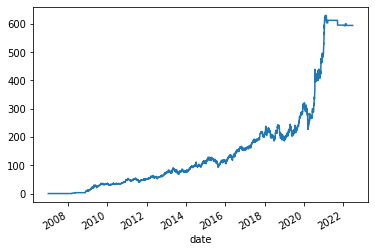

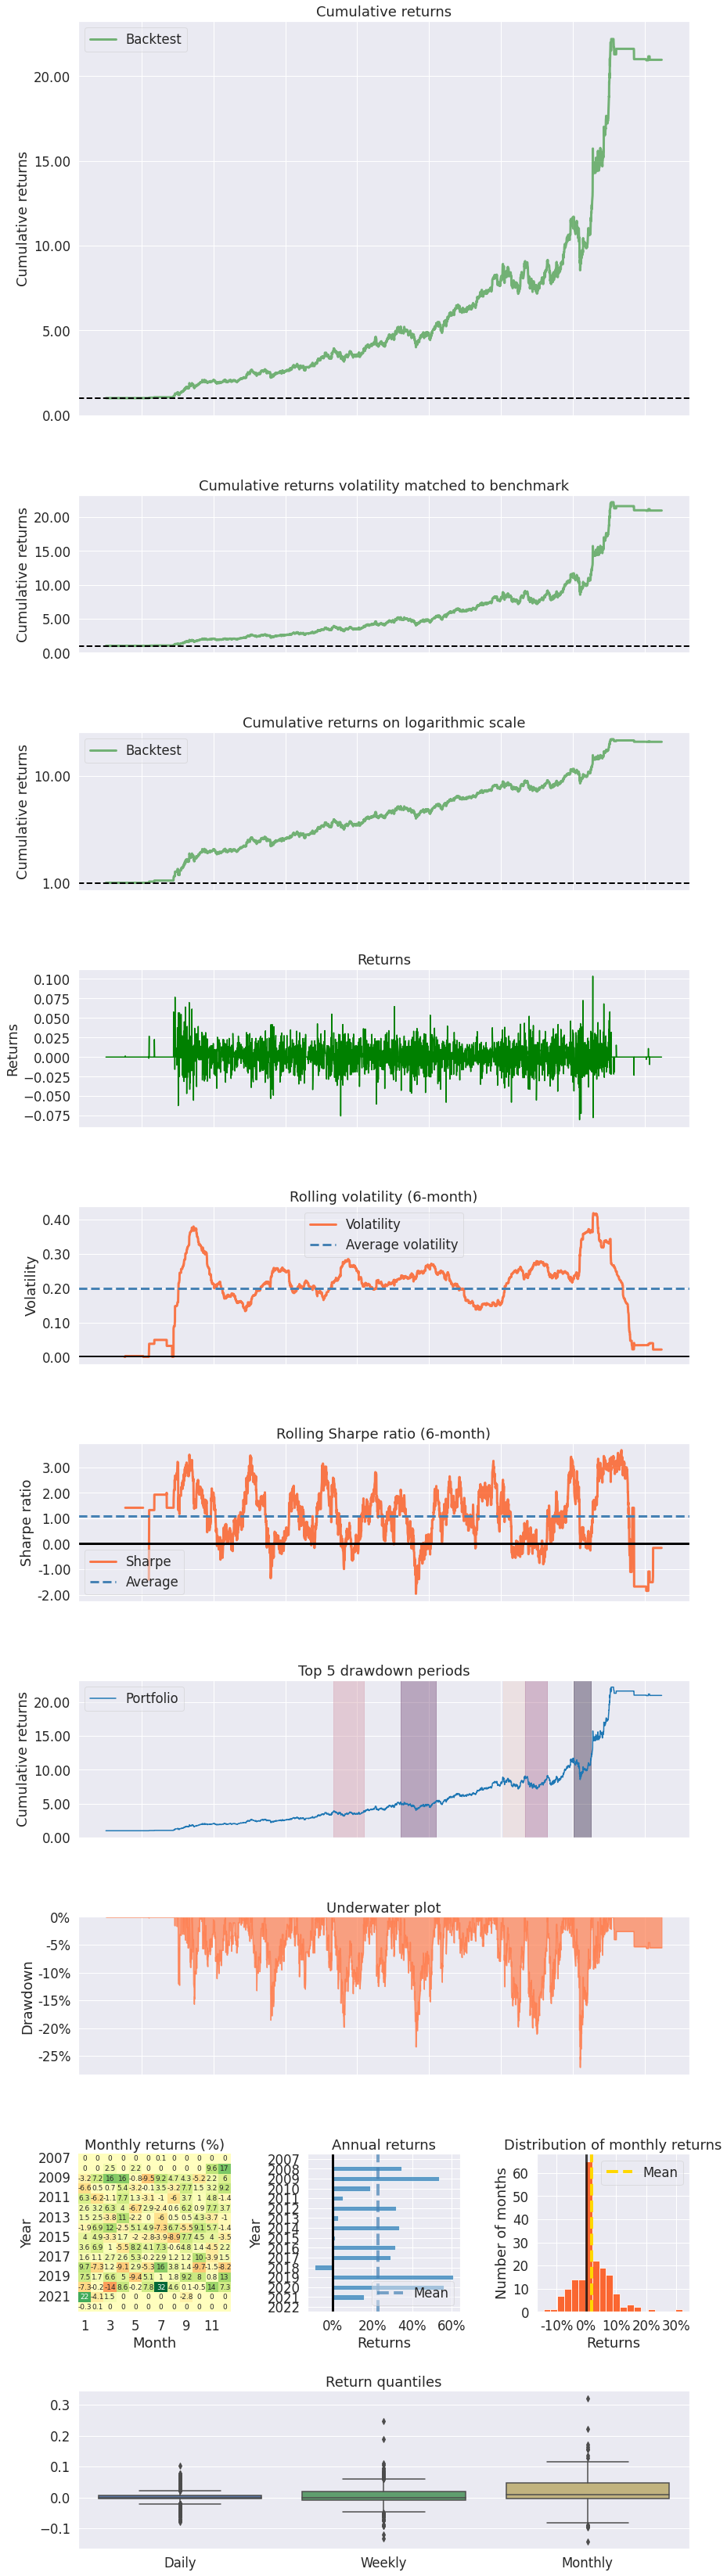

In [10]:
# 連續跌
condition = (df['close'].shift(2)-df['open'].shift(2)<0) & (df['close'].shift(1)-df['open'].shift(1)<0) & (df['close']-df['open']<0)
df.loc[condition,'hold_連續跌'] = 1
df['hold_連續跌'] = df['hold_連續跌'].fillna(0)

# 創新高
df['hold_創新高'] = np.nan
condition_buy = (df['close'].rolling(64).max() == df['close'])
condition_sell = df['close']<df['close'].rolling(78).mean()

df.loc[condition_buy,'hold_創新高'] = 1
df.loc[condition_sell,'hold_創新高'] = 0

df['hold_創新高'].ffill(inplace=True)
df['hold_創新高'] = df['hold_創新高'].fillna(0)

# KD
kd = abstract.STOCH(df,fastk_period=2,slowk_period=6,slowd_period=6)
df['k'] = kd['slowk']
df['d'] = kd['slowd']
df['hold_KD'] = np.nan
df.loc[(df['k'].shift(1)<df['d'].shift(1))&(df['k']>df['d'])&(df['d']<17),'hold_KD'] = 1
df.loc[(df['k'].shift(1)>df['d'].shift(1))&(df['k']<df['d'])&(df['d']>86),'hold_KD'] = 0
df['hold_KD'].ffill(inplace=True)
df['hold_KD'] = df['hold_KD'].fillna(0)

# RSI
rsi_short = abstract.RSI(df,timeperiod=27)
rsi_long = abstract.RSI(df,timeperiod=46)

df['rsi_short'] = rsi_short
df['rsi_long'] = rsi_long


df['hold_RSI'] = np.nan
df.loc[df['rsi_short']<30,'hold_RSI'] = 1
df.loc[(df['rsi_short']<df['rsi_long']) & (df['rsi_short'].shift(1)>df['rsi_long'].shift(1)) & (df['rsi_short']>62),'hold_RSI'] = 0 

df['hold_RSI'].ffill(inplace=True)
df['hold_RSI'] = df['hold_RSI'].fillna(0)

# 威廉
willr = abstract.WILLR(df,timeperiod = 4)

df['willr'] = willr

df['hold_willr'] = np.nan
df.loc[df['willr']<-62,'hold_willr'] = 1
df.loc[df['willr']>-8,'hold_willr'] = 0

df['hold_willr'].ffill(inplace=True)
df['hold_willr'] = df['hold_willr'].fillna(0)

# 乖離率
bias1 = (df['close']-df['close'].rolling(13).mean())/df['close']
bias2 = (df['close']-df['close'].rolling(15).mean())/df['close']


df['hold_bias'] = np.nan
df.loc[(bias1>-0.159)&(bias2<-0.159),'hold_bias'] = 1
df.loc[(bias1<0.12)&(bias2>0.12),'hold_bias'] = 0

df['hold_bias'].ffill(inplace=True)
df['hold_bias'] = df['hold_bias'].fillna(0)

df = df.drop(['k','d','rsi_short','rsi_long','willr'],axis=1)

df['hold_number'] = df['hold_連續跌']+df['hold_創新高']+df['hold_KD']+df['hold_RSI']+df['hold_willr']+df['hold_bias']

df['real_hold']=np.nan
df.loc[df['hold_number']>=3,'real_hold'] = 1
df.loc[df['hold_number']<=2,'real_hold'] = 0
df['real_hold'].ffill(inplace=True)
df['real_hold'] = df['real_hold'].fillna(0)

df['earn'] = 0
df.loc[df['real_hold']==1,'earn'] = df['open'].shift(-2)-df['open'].shift(-1)

df['earn'].cumsum().plot()

import pyfolio as pf
pf.create_returns_tear_sheet(df['earn']/df['open'].shift(-1))

df

Start date,2007-01-02
End date,2022-06-24
Total months,181
,Backtest
Annual return,19.515%
Cumulative returns,1384.213%
Annual volatility,21.569%
Sharpe ratio,0.93
Calmar ratio,0.72
Stability,0.97
Max drawdown,-27.062%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.06,2020-01-10,2020-03-17,2020-07-07,128
1,23.38,2015-03-19,2015-08-21,2016-03-09,255
2,21.08,2018-09-04,2019-01-02,2019-04-17,162
3,19.83,2013-05-07,2013-08-19,2014-03-11,221
4,19.77,2018-01-22,2018-06-26,2018-08-28,157


,open,high,low,close,volume,hold_連續跌,hold_創新高,hold_KD,hold_RSI,hold_willr,hold_bias,hold_number,real_hold,earn,手續費,real_earn
date,,,,,,,,,,,,,,,,
2007-01-02,67.8,68.0,67.3,67.7,1768131919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-03,67.8,68.7,67.5,68.0,2875024398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-04,67.7,68.1,67.6,67.7,1514454033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-05,67.5,67.7,66.5,66.9,2048997239,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2007-01-08,66.1,66.5,65.7,65.8,1595029837,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-20,500.0,502.0,495.0,498.0,18267359790,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-06-21,501.0,505.0,499.0,505.0,17298234720,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-06-22,501.0,503.0,494.5,494.5,16630857096,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


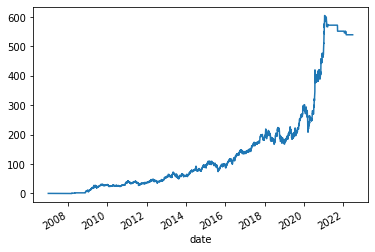

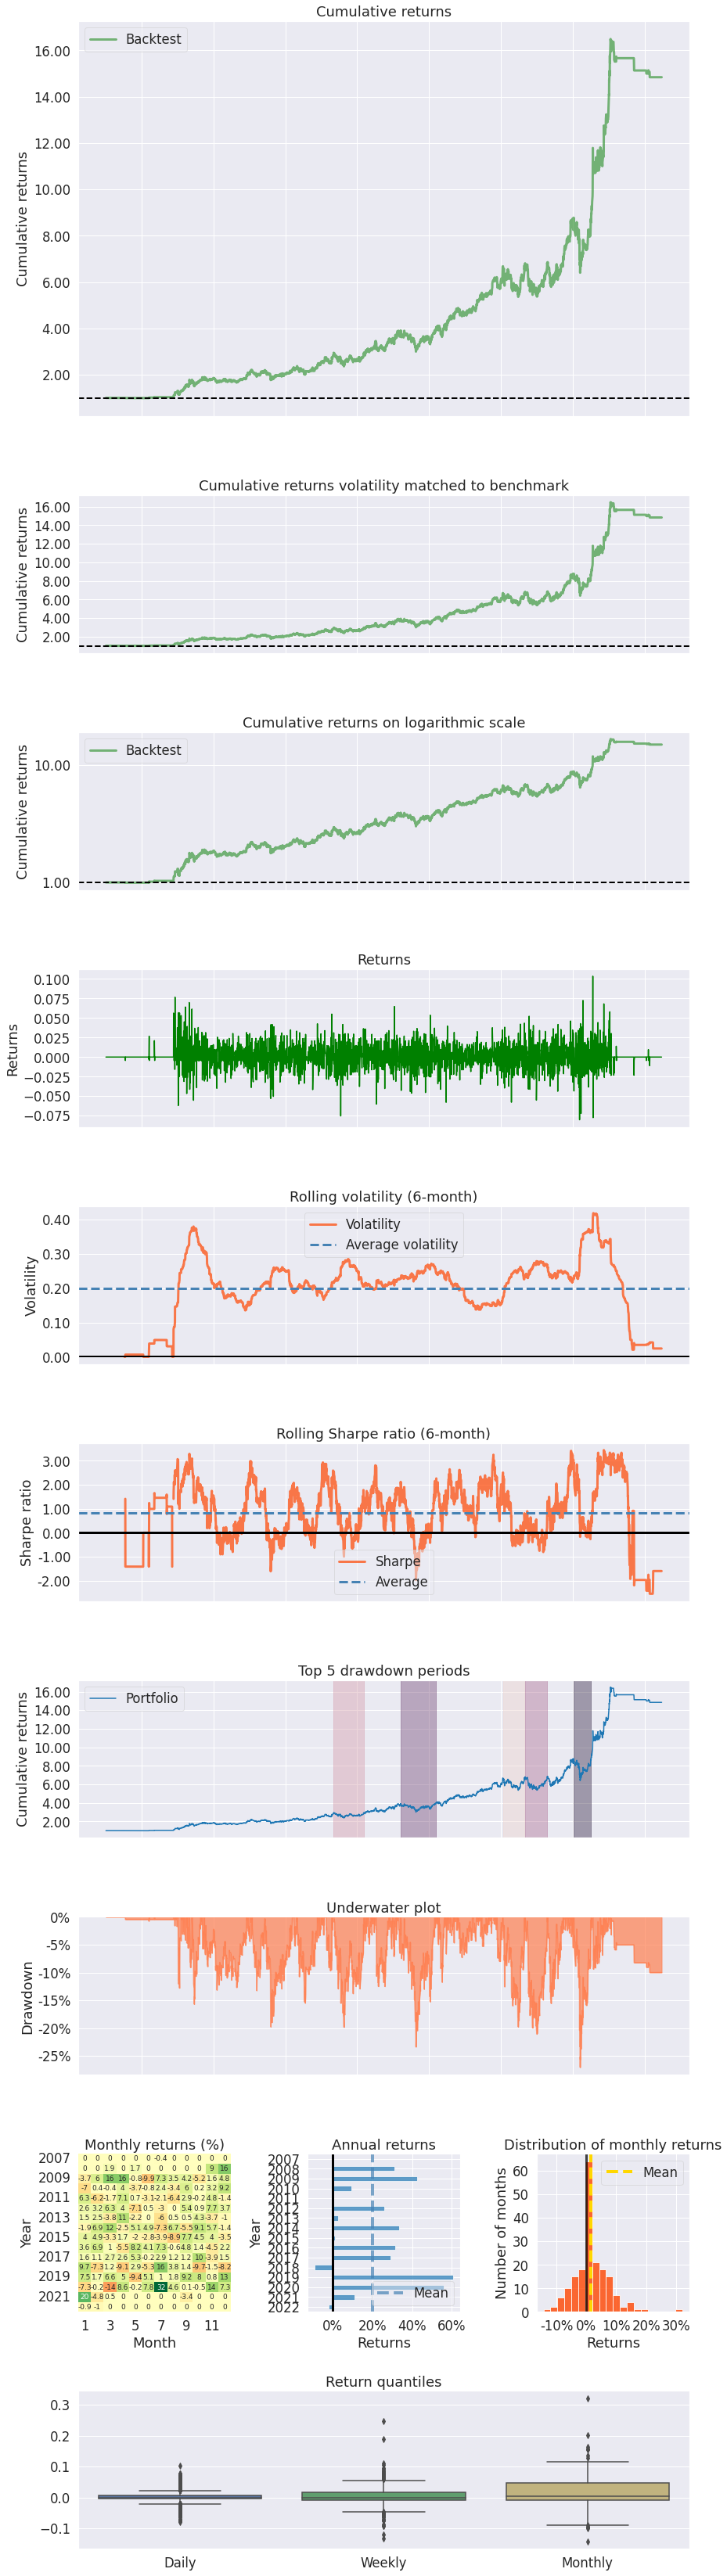

In [15]:
df['手續費'] = 0
df.loc[df['real_hold'].diff()==1,'手續費'] = df['open'].shift(-1)*0.001425
df.loc[df['real_hold'].diff()==-1,'手續費'] = df['open'].shift(-1)*(0.003+0.001425)

df['real_earn'] = 0
df['real_earn'] = df['earn'] - df['手續費']

df['real_earn'].cumsum().plot()

import pyfolio as pf
pf.create_returns_tear_sheet(df['real_earn']/df['open'].shift(-1))

df